# **REINFORCE [Solutions]**

<img src="https://drive.google.com/thumbnail?id=1sNbFSGUMoRekB-3eZsrjOyK9uo4l7GuG" alt="Robot says hello!">

<hr>

### **Part 7**: Reinforcement Learning (from Zero to One)

*African Institute for Mathematical Sciences (AIMS), South Africa
12 November, 2024*

**Arnu Pretorius** - Staff Research Scientist, InstaDeep

*Credits*: Adapted from Deep Learning Indaba 2022. Apache License 2.0.


## Setup

In [8]:
import time
import matplotlib.pyplot as plt # graph plotting library
from IPython.display import HTML
from base64 import b64encode
import chex

In [11]:
!pip install gymnasium
!pip install jaxlib
!pip install jax
!pip install git+https://github.com/deepmind/dm-haiku
!pip install gym==0.25
!pip install gym[box2d]
!pip install optax
!pip install matplotlib
!pip install chex

  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-e0_s_7a8
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/dm-haiku /tmp/pip-req-build-e0_s_7a8
  Resolved https://github.com/deepmind/dm-haiku to commit 72c6db405ae9450b0e5b0a8d164d92b44d96796d
  Preparing metadata (setup.py) ... done
  Created wheel for dm-haiku: filename=dm_haiku-0.0.14.dev0-py3-none-any.whl size=373527 sha256=a5322c46f4c1eab8dd563bd9bf0b69f2e3e87d7f2fa30b07b0ef5c527b21092c
  Stored in directory: /tmp/pip-ephem-wheel-cache-zu6jbe2y/wheels/b1/df/f1/a357fa8f00c36052bdae1e1fd363650c0bd1e8c3959487b6fb
Successfully built dm-haiku
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.4/720.4 kB 15.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.25.0-py3-none-any.whl size=824409 sha256=7aed079d4a4876c3a3400af1407e323135f9f46d2f3fcbf6

In [12]:
from shutil import rmtree # deleting directories
import random
import pickle
import collections # useful data structures
import numpy as np
from gymnasium.wrappers import RecordVideo
import jax
import jax.numpy as jnp # jax numpy
import haiku as hk # jax neural network library
import optax # jax optimizer library
import matplotlib.pyplot as plt # graph plotting library
from collections import namedtuple
import warnings
warnings.filterwarnings('ignore')
import gymnasium as gym

### **Environment (LunarLander-v2)**


In [ ]:

# Create the environment
env_name = "LunarLander-v2"
env = gym.make(env_name)

# Reset the environment
s_0 = env.reset()[0]
print("Initial State::", s_0)

# Get environment obs space
obs_shape = env.observation_space.shape
print("Environment Obs Space Shape:", obs_shape)

# Get action space - e.g. discrete or continuous
print(f"Environment action space: {env.action_space}")

# Get num actions
num_actions = env.action_space.n
print(f"Number of actions: {num_actions}")

#  Some helper functions

# Function to save logs to a file
def save_logs(logs, file_name="training_logs.txt"):
    with open(file_name, "a") as log_file:  # "a" mode to append logs if the file already exists
        log_file.write("\n".join(logs) + "\n")

# Function to save model parameters
def save_model_parameters(params, file_name="learned_params.pkl"):
    with open(file_name, "wb") as param_file:
        pickle.dump(params, param_file)

# Function to save the episode returns list
def save_episode_returns(returns_list, file_name="episode_returns.pkl"):
    with open(file_name, "wb") as file:
        pickle.dump(returns_list, file)

Initial State:: [ 0.00532827  1.4153526   0.5396849   0.19698907 -0.00616739 -0.1222467
  0.          0.        ]
Environment Obs Space Shape: (8,)
Environment action space: Discrete(4)
Number of actions: 4


## **Policy Gradients (PG)**
The goal in RL is to find a policy which maximise the expected cummulative reward (return) the agent receives from the environment. As shown in class, we have a wide array of algorithms depending on the representation of the return, denoted $Ψ$. In general then, we can write the RL objective as:

$$J(\pi_\theta)=\mathrm{E}_{\tau\sim\pi_\theta}\ [Ψ(\tau)],$$

where $\pi_\theta$ is a policy parametrised by $\theta$, $\mathrm{E}$ means *expectation*, $\tau$ is shorthand for "*episode*", $\tau\sim\pi_\theta$ is shorthand for "*episodes sampled using the policy* $\pi_\theta$", and $Ψ(\tau)$ is a *representation* of the return of episode $\tau$, which could simply be the return itself, i.e. $Ψ(\tau) = G(\tau)$.

Then, the goal in RL is to find the parameters $\theta$ that maximise the function $J(\pi_\theta)$. One way to find these parameters is to perform gradient *ascent* on $J(\pi_\theta)$ with respect to the parameters $\theta$:

$$\theta_{k+1}=\theta_k + \alpha \nabla J(\pi_\theta)|_{\theta_{k}},$$

where $\nabla J(\pi_\theta)|_{\theta_{k}}$ is the gradient of the expected return with respect to the policy parameters $\theta_k$ and $\alpha$ is the step size. This quantity, $\nabla J(\pi_\theta)$, is also called the **policy gradient** and is very important in RL. If we can compute the policy gradient, then we will have a means by which to directly optimise our policy.

As it turns out, as we saw in class, we can compute the policy gradient as follows:


$$\nabla_{\theta} J(\pi_{\theta})=\underset{\tau \sim \pi_{\theta}}{\mathrm{E}}[\sum_{t=0}^{T} Ψ_t \nabla_{\theta} \log \pi_{\theta}(a_{t} \mid s_{t})]$$

Informaly, the policy gradient is equal to the gradient of the log of the probability of the action chosen, multiplied by the (estimated) return of the episode in which the action was taken.


### **REINFORCE**
REINFORCE is a simple RL algorithm that uses the policy gradient to find the optimal policy by increasing the probability of choosing actions (reinforcing actions) that tend to lead to high return, as computed directly by $G(\tau)$.

---
> **For you!**
>
> Implement a function that takes the probability of an action and the return of the episode the action was taken in and computes the log of the probability, multiplied by the return.
---

**Useful functions:**
*   `jnp.log`([docs](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.log.html)) [Note: we have `import jax.numpy as jnp`]

In [ ]:

def compute_weighted_log_prob(action_prob, episode_return):

    # YOUR CODE

    log_prob = jnp.log(action_prob)

    weighted_log_prob = log_prob * episode_return

    # END YOUR CODE

    return weighted_log_prob


In [ ]:
#@title Check your implementation (run me) {display-mode: "form"}

try:
  action_prob = 0.8
  episode_return = 100
  result = compute_weighted_log_prob(action_prob, episode_return)
  if result != -22.314354:
    print("Oops! Your implementation looks incorrect.")
  else:
    print("Looks good!")
except Exception as e:
    print("Oops! Your implementation looks incorrect.")

Looks good!


### **Return**

---
> **For you!**
>
> Implement a function that takes a list of all the rewards obtained in an episode and computes the return for each step.
---

In [ ]:
def compute_returns(rewards, gamma=0.99):
    """
    This function should take a list of rewards as input and
    compute the return for each timestep.

    EXAMPLE: compute_returns([1,2,3,4]) = [10, 9, 7, 4], if gamma=1

    Arguments:
        rewards[t]: is the reward at time step t.
        gamma: discount factor

    -- IMPORTANT: use the default discount to check your implementation

    Returns:
        returns[t] should be the return at timestep t.
    """
    returns = []
    for i in range(len(rewards)):
        G = 0
        for j in range(i, len(rewards)):
            G += (gamma**(j-i))*rewards[j]
        returns.append(G)
    return returns

In [ ]:
#@title Check your implementation (run me) {display-mode: "form"}

try:
  result = compute_returns([1,2,3,4])

  if result != [9.801496, 8.8904, 6.96, 4.0]:
    print("Oops! Your implementation looks incorrect.")
  else:
    print("Looks good!")
except Exception as e:
    print("Oops! Your implementation looks incorrect.")


Looks good!


### **REINFORCE memory**
Next we will need to make a new agent memory to store the returns $G_t$ along with the observation $o_t$ and action $a_t$ at every timestep. Below we implemented such a memory module for you. The function `memory.sample()` will return a batch of the last 500 memories. You are welcome to read through the code to try and understand it, but it is not required. Therefore, we hide the code by default.

In [ ]:
# NamedTuple to store memory
EpisodeReturnsMemory = collections.namedtuple("EpisodeReturnsMemory", ["obs", "action", "returns"])

class EpisodeReturnsBuffer:

    def __init__(self, num_transitions_to_store=512, batch_size=256):
        self.batch_size = batch_size
        self.memory_buffer = collections.deque(maxlen=num_transitions_to_store)
        self.current_episode_transition_buffer = []

    def push(self, transition):
        self.current_episode_transition_buffer.append(transition)
        done = transition.terminated or transition.truncated
        if done:
            episode_rewards = []
            for t in self.current_episode_transition_buffer:
                episode_rewards.append(t.reward)

            G = compute_returns(episode_rewards)

            for i, t in enumerate(self.current_episode_transition_buffer):
                memory = EpisodeReturnsMemory(t.obs, t.action, G[i])
                self.memory_buffer.append(memory)

            # Reset episode buffer
            self.current_episode_transition_buffer = []


    def is_ready(self):
        return len(self.memory_buffer) >= self.batch_size

    def sample(self):
        random_memory_sample = random.sample(self.memory_buffer, self.batch_size)

        obs_batch, action_batch, returns_batch = zip(*random_memory_sample)

        return EpisodeReturnsMemory(
            np.stack(obs_batch).astype("float32"),
            np.asarray(action_batch).astype("int32"),
            np.asarray(returns_batch).astype("int32")
        )
# Instantiate Memory
REINFORCE_memory = EpisodeReturnsBuffer(num_transitions_to_store=512, batch_size=128)


### **Policy neural network**
Next, we will use a simple neural network to aproximate the policy. Our policy neural network will have an input layer that takes the observation as input and passes it through two hidden layers and then outputs one scalar value for each of the possible actions. So, in CartPole the output layer will have size `2`.

[Haiku](https://github.com/deepmind/dm-haiku) is a library for implementing neural networks is JAX. Below we have implemented a simple function to make the policy network for you.


In [ ]:

def make_policy_network(num_actions: int, layers=[20, 20]) -> hk.Transformed:
  """Factory for a simple MLP network for the policy."""

  def policy_network(obs):
    network = hk.Sequential(
        [
            hk.Flatten(),
            hk.nets.MLP(layers + [num_actions])
        ]
    )
    return network(obs)

  return hk.without_apply_rng(hk.transform(policy_network))



Haiku networks have two important functions you need to know about. The first is the `network.init(<random_key>, <input>)`, which returns a set of random initial parameters. The second method is the `network.apply(<params>, <input>)` which passes an input through the network using the set of parameters provided.

In [ ]:
# Example
POLICY_NETWORK = make_policy_network(num_actions = num_actions, layers=[28,28])
random_key = jax.random.PRNGKey(0) # random key
dummy_obs = np.ones(obs_shape, "float32")

# Initialise parameters
REINFORCE_params = POLICY_NETWORK.init(random_key, dummy_obs)
print("Initial params:", REINFORCE_params.keys())

# Pass input through the network
output = POLICY_NETWORK.apply(REINFORCE_params, dummy_obs)
print("Policy network output:", output)


Initial params: dict_keys(['mlp/~/linear_0', 'mlp/~/linear_1', 'mlp/~/linear_2'])
Policy network output: [ 0.09457228 -0.1857481  -0.22041705  0.00728684]


The outputs of our policy network are [logits](https://qr.ae/pv4YTe). To convert this into a probability distribution over actions we pass the logits to the [softmax](https://en.wikipedia.org/wiki/Softmax_function) function.

### **REINFORCE action selector**

---
> **For you!**
>
> Complete the function below which takes a vector of logits and randomly samples an action from a categorical distibution given by the logits.
---

**Useful functions:**
*   `jax.random.categorical` ([docs](https://jax.readthedocs.io/en/latest/_autosummary/jax.random.categorical.html))

In [ ]:

def sample_action(random_key, logits):
    return jax.random.categorical(random_key,logits)



In [ ]:
#@title Check your implementation (run me) {display-mode: "form"}

try:
  random_key = jax.random.PRNGKey(42) # random key
  action = sample_action(random_key, np.array([1,2], "float32"))
  if action != 1:
    print("Oops! Your implementation looks incorrect.")
  else:
    print("Looks good!")
except Exception as e:
    print("Oops! Your implementation looks incorrect.")

Looks good!


Now we can implement the `REINFORCE_choose_action` function. We will pass the observation through the policy network to compute the logits and then pass the logits to the `sample_action` function to choose and action.

In [ ]:
def REINFORCE_choose_action(key, params, actor_state, obs, evaluation=False):
  obs = jnp.expand_dims(obs, axis=0) # add dummy batch dim before passing through network

  # Pass obs through policy network to compute logits
  logits = POLICY_NETWORK.apply(params, obs)
  logits = logits[0] # remove batch dim

  # Randomly sample action
  sampled_action = sample_action(key, logits)

  return sampled_action, actor_state

Now that we have  implemented the `REINFORCE_choose_action` function, all we have left to do is to make a `REINFORCE_learn` function. The learn function should use the `weighted_log_prob` function we made earlier to compute the policy gradient loss and apply the gradient updates to our neural network.

### **Policy gradient loss**

---
> **For you!**
>
> Complete the `policy_gradient_loss` function below. The function should compute the action probabilities by passing the `logits` through the softmax function. Then you should extract the probability of the given `action` (using array indexing) and compute the `weighted_log_prob` using the function we made earlier.
---

**Useful methods:**
*   `jax.nn.softmax` ([docs](https://jax.readthedocs.io/en/latest/_autosummary/jax.nn.softmax.html))

In [ ]:

def policy_gradient_loss(action, logits, returns):

  # YOUR CODE
  all_action_probs = jax.nn.softmax(logits) # convert logits into probs

  action_prob = all_action_probs[action]

  weighted_log_prob = compute_weighted_log_prob(action_prob, returns)

  # END YOUR CODE

  loss = - weighted_log_prob # negative because we want gradient `ascent`

  return loss

In [ ]:
#@title Check your implementation (run me) {display-mode: "form"}

try:
  result = policy_gradient_loss(1, np.array([1,2], "float32"), 10)
  if result != 3.1326165:
    print("Oops! Your implementation looks incorrect.")
  else:
    print("Looks good!")
except Exception as e:
  print("Oops! Your implementation looks incorrect.")


Looks good!


When we do a policy gradient update step we are going to want to do it using a batch of experience, rather than just a single experience like above. We can use JAX's [vmap](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html#jax.vmap) function to easily make our `policy_gradient_loss` function work on a batch of experience.

In [ ]:
def batched_policy_gradient_loss(params, obs_batch, action_batch, returns_batch):
    # Get logits by passing observation through network
    logits_batch = POLICY_NETWORK.apply(params, obs_batch)

    policy_gradient_loss_batch = jax.vmap(policy_gradient_loss)(action_batch, logits_batch, returns_batch) # add batch

    # Compute mean loss over batch
    mean_policy_gradient_loss = jnp.mean(policy_gradient_loss_batch)

    return mean_policy_gradient_loss

# TEST
obs_batch = np.ones((3, *obs_shape), "float32")
actions_batch = np.array([1,0,0])
returns_batch = np.array([2.3, 4.3, 2.1])

loss = batched_policy_gradient_loss(REINFORCE_params, obs_batch, actions_batch, returns_batch)

print("Policy gradient loss on batch:", loss)

Policy gradient loss on batch: 3.7653565


### **Network Optimiser**

To apply policy gradient updates to our neural network we will use a JAX library called [Optax](https://github.com/deepmind/optax). Optax has an implementation of the [Adam optimizer](https://www.geeksforgeeks.org/intuition-of-adam-optimizer/) which we can use.

In [ ]:
REINFORCE_OPTIMIZER = optax.adam(0.0001)

# Initialise the optimiser
REINFORCE_optim_state = REINFORCE_OPTIMIZER.init(REINFORCE_params)


Now we have everything we need tp make the `REINFORCE_learn` function. We will store the state of the optimiser in the `learn_state`. We will compute the gradient of the policy gradient loss by using `jax.grad` ([docs](https://jax.readthedocs.io/en/latest/_autosummary/jax.grad.html)).

In [ ]:

# A NamedTuple to store the state of the optimiser
REINFORCELearnState = collections.namedtuple("LearnerState", ["optim_state"])

def REINFORCE_learn(key, params, learner_state, memory):

  # Get the policy gradient by using `jax.grad()` on `batched_policy_gradient_loss`
  grad_loss = jax.grad(batched_policy_gradient_loss)(params, memory.obs, memory.action, memory.returns)

  # Get param updates using gradient and optimizer
  updates, new_optim_state = REINFORCE_OPTIMIZER.update(grad_loss, learner_state.optim_state)

  # Apply updates to params
  params = optax.apply_updates(params, updates)

  return params, REINFORCELearnState(new_optim_state) # update learner state




### **RL Training Loop**
As before, we provide the general RL training loop for you.

In [ ]:
#@title Training loop (run me) { display-mode: "form" }

# NamedTuple to store transitions
Transition = collections.namedtuple("Transition", ["obs", "action", "reward", "next_obs", "terminated", "truncated"])
# Training Loop
def run_training_loop(env_name, agent_params, agent_select_action_func,
    agent_actor_state=None, agent_learn_func=None, agent_learner_state=None,
    agent_memory=None, num_episodes=1000, evaluator_period=100,
    evaluation_episodes=10, learn_steps_per_episode=1,
    train_every_timestep=False, video_subdir="",):

    # Setup Cartpole environment and recorder
    env = gym.make(env_name, render_mode="rgb_array")        # training environment
    eval_env = gym.make(env_name, render_mode="rgb_array")   # evaluation environment

    # Video dir
    video_dir = "./video"+"/"+video_subdir

    # Clear video dir
    try:
      rmtree(video_dir)
    except:
      pass

    # Wrap in recorder
    env = RecordVideo(env, video_dir+"/train", episode_trigger=lambda x: (x % evaluator_period) == 0, disable_logger= True)
    eval_env = RecordVideo(eval_env, video_dir+"/eval", episode_trigger=lambda x: (x % evaluation_episodes) == 0,disable_logger=True)

    # JAX random number generator
    rng = hk.PRNGSequence(jax.random.PRNGKey(0))
    random.seed(0)

    episode_returns = []                     # List to store history of episode returns.
    evaluator_episode_returns = []           # List to store history of evaluator returns.
    timesteps = 0
    for episode in range(num_episodes):

        # Reset environment.
        obs = env.reset()[0]  # new way to seed the environment

        episode_return = 0
        done = False

        while not done:

            # Agent select action.
            action, agent_actor_state = agent_select_action_func(
                                            next(rng),
                                            agent_params,
                                            agent_actor_state,
                                            np.array(obs)
                                        )

            # Step environment.
            next_obs, reward, terminated, truncated, _ = env.step(int(action))
            done = terminated or truncated
            # Pack into transition.
            transition = Transition(obs, action, reward, next_obs, terminated, truncated)

            # Add transition to memory.
            if agent_memory: # check if agent has memory
              agent_memory.push(transition)

            # Add reward to episode return.
            episode_return += reward
            # Set obs to next obs before next environment step. CRITICAL!!!
            obs = next_obs

            # Increment timestep counter
            timesteps += 1

            # Maybe learn every timestep
            if train_every_timestep and (timesteps % 4 == 0) and agent_memory and agent_memory.is_ready(): # Make sure memory is ready
                # First sample memory and then pass the result to the learn function
                memory = agent_memory.sample()
                agent_params, agent_learner_state = agent_learn_func(
                                                        next(rng),
                                                        agent_params,
                                                        agent_learner_state,
                                                        memory
                                                    )# Ma fihimta

        episode_returns.append(episode_return)

        # At the end of every episode we do a learn step.
        if agent_memory and agent_memory.is_ready(): # Make sure memory is ready

            for _ in range(learn_steps_per_episode):
                # First sample memory and then pass the result to the learn function
                memory = agent_memory.sample()
                agent_params, agent_learner_state = agent_learn_func(
                                                        next(rng),
                                                        agent_params,
                                                        agent_learner_state,
                                                        memory
                                                    )

        if (episode % evaluator_period) == 0: # Do evaluation

            evaluator_episode_return = 0
            for eval_episode in range(evaluation_episodes):
                obs = eval_env.reset()[0]
                done = False
                while not done:
                    action, _ = agent_select_action_func(
                                    next(rng),
                                    agent_params,
                                    agent_actor_state,
                                    np.array(obs),
                                    evaluation=True
                                )

                    obs, reward, terminated, truncated, _ = eval_env.step(int(action))
                    done = terminated or truncated

                    evaluator_episode_return += reward

            evaluator_episode_return /= evaluation_episodes

            evaluator_episode_returns.append(evaluator_episode_return)

            logs = [
                    f"Episode: {episode}",
                    f"Episode Return: {episode_return}",
                    f"Average Episode Return: {np.mean(episode_returns[-20:])}",
                    f"Evaluator Episode Return: {evaluator_episode_return}"
            ]

            print(*logs, sep="\t") # Print the logs

    env.close()
    eval_env.close()

    return episode_returns, evaluator_episode_returns


### **REINFORCE training loop**
Now we can train our REINFORCE agent by putting everything together using the training loop.

In [ ]:
# JIT the choose_action and learn functions for more speed
REINFORCE_learn_jit = jax.jit(REINFORCE_learn)
REINFORCE_choose_action_jit = jax.jit(REINFORCE_choose_action)


In [ ]:
# Initial learn state
REINFORCE_learn_state = REINFORCELearnState(REINFORCE_optim_state)

# Run training loop
print("Starting training. This may take a few minutes to complete.")
episode_returns, evaluator_returns = run_training_loop(
                                        env_name,
                                        REINFORCE_params,
                                        REINFORCE_choose_action_jit,
                                        None, # action state not used
                                        REINFORCE_learn_jit,
                                        REINFORCE_learn_state,
                                        REINFORCE_memory,
                                        num_episodes=25001,
                                        learn_steps_per_episode = 4,                # this has changed
                                        video_subdir="Lunalanderreinforce")




Starting training. This may take a few minutes to complete.
Episode: 0	Episode Return: -121.08498796864944	Average Episode Return: -121.08498796864944	Evaluator Episode Return: -105.35446912086941
Episode: 100	Episode Return: -20.707295921905967	Average Episode Return: -128.58202973174798	Evaluator Episode Return: -109.18754706993502
Episode: 200	Episode Return: -149.8053946254915	Average Episode Return: -144.56406095715133	Evaluator Episode Return: -117.81699199649663
Episode: 300	Episode Return: -119.25246544701695	Average Episode Return: -153.87939984172186	Evaluator Episode Return: -87.38993569624651
Episode: 400	Episode Return: -39.76637500893885	Average Episode Return: -118.18625619102951	Evaluator Episode Return: -122.17918955402556
Episode: 500	Episode Return: -118.71564718537614	Average Episode Return: -121.92568525198631	Evaluator Episode Return: -109.04101234361629
Episode: 600	Episode Return: -70.53297886180232	Average Episode Return: -131.21156853035006	Evaluator Episode R

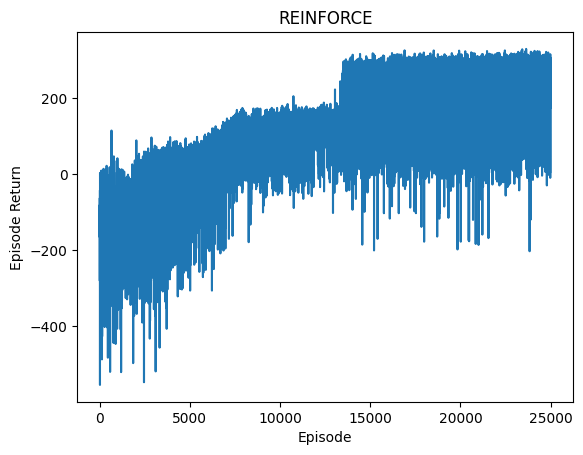

In [ ]:

save_model_parameters(REINFORCE_params, "./ass2b/learned_params.pkl")
save_episode_returns(episode_returns, file_name="./ass2b/episode_returns.pkl")
# Plot the episode returns
plt.plot(range(len(episode_returns)), episode_returns)  #Corrected-the-plot-call
plt.xlabel("Episode")
plt.ylabel("Episode Return")
plt.title("REINFORCE")
plt.savefig('./ass2b/llreinforce_loss.pdf')
plt.show()

In [15]:
#@title Visualise Policy {display-mode: "form"}
#@markdown Choose an episode number that is a multiple of 100 and less than or equal to 1000, and **run this cell**.

episode_number = 1750 #@param {type:"number"}


eval_episode_number = int(episode_number / 100 * 8)
video_path ="/content/rl-video-episode-2500.mp4"


mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

## **Now... back to earth!**

<center>
<img src="https://miro.medium.com/max/1194/1*Dj2fkRjrMA0w9E-PuyETdg.gif" width="60%" />
</center>

Once you have successfully solved CartPole using REINFORCE, you should use what you have learned to help Steve land safely back on earth!

You will again use the (now think "earthLander") [LunarLander](https://www.gymlibrary.ml/environments/box2d/lunar_lander/) environment. As last time, go to the start of the notebook and replace the environment with LunarLander by replacing `env = gym.make("CartPole-v1")` with env = `gym.make("LunarLander-v2")`.